2023-09-23 16:57:35.166 python[67493:5392066] +[CATransaction synchronize] called within transaction


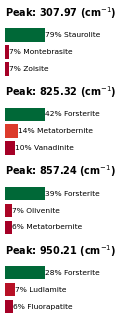

In [3]:
import time
import tkinter as tk
import os
import numpy as np
import re
import requests
import zipfile
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import matplotlib.collections as mc
import matplotlib.backends.backend_tkagg as tkagg
import threading
import traceback
import threading
import traceback
import sqlite3

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tkinter import ttk, filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from tkinter import Button
from matplotlib.backends.backend_tkagg import NavigationToolbar2Tk
from scipy.linalg import cholesky
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
from scipy.sparse import csc_matrix, diags
from scipy.special import wofz
from IPython.display import display, Image
from PIL import Image, ImageTk 


def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-(x - mean)**2 / (2 * stddev**2))

def lorentzian(x, amp, mean, gamma):
    return amp * (gamma**2) / ((x - mean)**2 + gamma**2)

def voigt(x, amp, mean, stddev, gamma):
    z = (x - mean + 1j * gamma) / (stddev * np.sqrt(2))
    denominator = stddev * np.sqrt(2 * np.pi)

    # Check for potential division by zero or very small values
    if np.any(np.abs(denominator) < 1e-10):
        print("Division by zero or small denominator encountered.")
        voigt_profile = np.zeros_like(x)
    else:
        wofz_result = wofz(z)
        voigt_profile = amp * np.real(wofz_result / denominator)
        
    return voigt_profile



def pseudo_voigt(x, amp, mean, stddev, fraction):
    return fraction * lorentzian(x, amp, mean, stddev) + (1 - fraction) * gaussian(x, amp, mean, stddev)


class RamanAnalyzer:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Raman Analysis")
        self.root.geometry("1200x650")
        self.root.minsize(1200, 650)  # Set the minimum size

        self.fit_model_var = tk.StringVar(value='Gaussian')  # Initialize the variable
        
        self.checkboxes = []
        self.checkboxes_t2 = []
        #self.lines = []
        self.peaks = []
        self.checkbox_vars = []
        self.lines_fg2 = []  # Create an empty list to store the line objects

        self.spectrumFigure4 = None
        self.spectrumFigure1 = None
        self.figure3 = None
        self.is_plotting = False
        self.plot_thread = None
        self.check_match_done_thread = None

        self.cancel_flag = threading.Event()
        self.cancel_flag.clear()

        self.removed_peak_data = []  # Initialize the attribute
        
        self.current_peak_index = 0
        self.initial_amp_guess = 1.0
        self.initial_mean_guess = 1000.0
        self.initial_stddev_guess = 10.0
        self.initial_gamma_guess = 1.0
        self.initial_fraction_guess = 0.5
        
        self.param_names = []
        self.model_param_names = {
            'Gaussian': ['Amplitude', 'Mean', 'Sigma'],
            'Lorentzian': ['Amplitude', 'Mean', 'Gamma'],
            'Voigt': ['Amplitude', 'Mean', 'Sigma', 'Gamma'],
            'Pseudo-Voigt': ['Amplitude', 'Mean', 'Sigma', 'Fraction']
        }
        
        self.create_GUI()
        self.database_tab_display()
        self.auto_config_display()
        
        #Create a button for background subtraction in panel 2
        self.subtract_background_button_t2 = tk.Button(self.tab2, text="Bg", command=self.subtract_backgroundFigure4)
        self.subtract_background_button_t2.place(relx=0.01, rely=0.165, relwidth=0.03, relheight=0.05)
        self.subtract_background_button_t2.configure(state="disabled", anchor="center")  # Initially disabled
        self.background_subtraction_activeFigure4 = False
        self.original_spectrumFigure4 = None  # Initialize the variable for storing the original data
    
        # Create a button for background subtraction in panel 3
        self.subtract_background_button_t3 = tk.Button(self.tab3, text="Bg", command=self.subtract_backgroundFigure1)
        self.subtract_background_button_t3.place(relx=0.01, rely=0.165, relwidth=0.03, relheight=0.05)
        self.subtract_background_button_t3.configure(state="disabled")  # Initially disabled
        self.background_subtraction_activeFigure1 = False
        self.original_spectrumFigure1 = None  # Initialize the variable for storing the original data
        
        self.conn = sqlite3.connect("RRUFFRaman_databaseSEARCH.db")
        self.cursor = self.conn.cursor()

        self.search_var = tk.StringVar()
        self.search_var.trace("w", self.update_search)

        self.search_entry = tk.Entry(self.tab2, textvariable=self.search_var)
        self.search_entry.place(relx=0.08, rely=0.45, relwidth=0.1, relheight=0.05)

        self.results_listbox = None
        self.selected_filename = None
        

    def update_search(self, *args):
        search_term = self.search_var.get().lower()

        if search_term:
            self.show_results(search_term)
        else:
            self.hide_results()

    def show_results(self, search_term):
        if self.results_listbox:
            self.results_listbox.destroy()

        self.results_listbox = tk.Listbox(self.tab2)
        self.results_listbox.place(relx=0.08, rely=0.5, relwidth=0.1, relheight=0.2)

        query = "SELECT filename, x_data, y_data FROM database_tableSEARCH WHERE filename LIKE ?"
        self.cursor.execute(query, ('%' + search_term + '%',))
        results = self.cursor.fetchall()

        for row in results:
            filename, x_data, y_data = row
            self.results_listbox.insert(tk.END, filename)

        self.results_listbox.bind("<<ListboxSelect>>", self.on_select)

    def hide_results(self):
        if self.results_listbox:
            self.results_listbox.destroy()
            self.results_listbox = None

    def plot_selected_data(self):
        global show_figure5_output  # Access the global variable
        try:
            if self.selected_filename:
                query = "SELECT x_data, y_data FROM database_tableSEARCH WHERE filename = ?"
                self.cursor.execute(query, (self.selected_filename,))
                x_data_str, y_data_str = self.cursor.fetchone()

                x_data = [float(val) for val in x_data_str.strip('[]').split(', ')]
                y_data = [float(val) for val in y_data_str.strip('[]').split(', ')]
                
                # Normalize y_data
                max_intensity = max(y_data)
                y_data_normalized = [val / max_intensity for val in y_data]


                # Clear previous data in ax5 and plot new data
                self.ax5.clear()
                line, = self.ax5.plot(x_data, y_data_normalized, label=self.selected_filename)  # Set the legend label to the filename

                # Set labels, title, and tick parameters
                self.ax5.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
                self.ax5.set_ylabel('Intensity (normalized)', fontsize=16)
                self.ax5.set_title("Reference Files", loc='left', fontsize=16)
                self.ax5.tick_params(axis='x', labelsize=16)
                self.ax5.tick_params(axis='y', labelsize=16)

                # Add legend
                self.ax5.legend(loc='upper left', fontsize=14)

                # Redraw the figure
                self.canvas5.draw()

        except Exception as e:
            printed_text = "Reference file(s) loaded has incorrect format"
            self.text_field.insert("1.0", printed_text + "\n")
            print(e)

    def on_select(self, event):
        selected_idx = self.results_listbox.curselection()
        if selected_idx:
            self.selected_filename = self.results_listbox.get(selected_idx[0])
            self.plot_selected_data()

            # Hide the results listbox upon selection
            self.hide_results()

  







    def enforce_minimum_size(self, event):
        # Enforce the minimum size when the window is resized
        if self.root.winfo_width() < 1200:
            self.root.geometry("1200x{}".format(self.root.winfo_height()))
        if self.root.winfo_height() < 800:
            self.root.geometry("{}x800".format(self.root.winfo_width()))   

    def create_GUI(self):
        # Create the tab control
        tab_control = ttk.Notebook(self.root)
        tab_control.pack(fill='both', expand=True)

        # Create the first tab - INSTRUCTION
        self.tab1 = ttk.Frame(tab_control)
        tab_control.add(self.tab1, text='Instructions')

        # Create the second tab with three panels (horizontal) - MANUAL
        self.tab2 = ttk.Frame(tab_control)
        tab_control.add(self.tab2, text='Manual')

        self.panel2_1 = tk.LabelFrame(self.tab2, text="Configuration", padx=10, pady=10)
        self.panel2_1.place(relx=0.005, rely=0.005, relwidth=0.20, relheight=0.988)

        self.panel2_2 = tk.LabelFrame(self.tab2, text="", padx=10, pady=10)
        self.panel2_2.place(relx=0.200, rely=0.005, relwidth=0.54, relheight=0.988)
        
        self.panel2_3 = tk.LabelFrame(self.tab2, text="", padx=10, pady=10)
        self.panel2_3.place(relx=0.720, rely=0.005, relwidth=0.28, relheight=0.988)
        
        # Adjust the placement of the canvas and table frame
        self.canvas = tk.Canvas(self.panel2_3)
        self.canvas.pack(fill="both", expand=True)

        self.table_frame = ttk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.table_frame, anchor="nw")

        # Configure the table_frame to fill the canvas both horizontally and vertically
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        # Set the scrollable region to match the initial size of the canvas
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

        self.table = ttk.Treeview(self.table_frame, show='headings')
        self.table["columns"] = ("column1", "column2", "column3", "column4", "column5", "column6", "column7", "column8", "column9")
        self.table.heading("column1", text="Peak", anchor="w")
        self.table.heading("column2", text="Amplitude", anchor="w")
        self.table.heading("column3", text="Mean", anchor="w")
        self.table.heading("column4", text="Sigma", anchor="w")
        self.table.heading("column5", text="Gamma", anchor="w")
        self.table.heading("column6", text="Fraction", anchor="w")
        self.table.heading("column7", text="FWHM", anchor="w")
        self.table.heading("column8", text="Height", anchor="w")
        self.table.heading("column9", text="Area", anchor="w")

        # Calculate column widths based on the length of the column headings
        column_widths = [len(self.table.heading(column)["text"]) for column in self.table["columns"]]

        # Set column widths
        for i, column in enumerate(self.table["columns"]):
            self.table.column(column, width=column_widths[i] * 10)  # Adjust the multiplier as needed

        self.table.pack(fill="both", expand=True)
        
        h_scrollbar = ttk.Scrollbar(self.panel2_3, orient="horizontal", command=self.canvas.xview)
        self.canvas.configure(xscrollcommand=h_scrollbar.set)
        h_scrollbar.pack(side="bottom", fill="x")
        self.canvas.config(xscrollcommand=h_scrollbar.set)

        v_scrollbar = ttk.Scrollbar(self.tab2, orient="vertical", command=self.canvas.yview)
        self.canvas.configure(yscrollcommand=v_scrollbar.set)
        v_scrollbar.pack_forget()
        v_scrollbar.config(command=self.canvas.yview)


        # Bind the canvas scrolling to the scrollbar
        self.table_frame.bind("<Configure>", self.on_frame_configure)
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        # Create the third tab with three panels (horizontal) - AUTO
        self.tab3 = ttk.Frame(tab_control)
        tab_control.add(self.tab3, text='Auto')

        self.panel3_1 = tk.LabelFrame(self.tab3, text="Configuration", padx=10, pady=10)
        self.panel3_1.place(relx=0.005, rely=0.005, relwidth=0.20, relheight=0.988)

        self.panel3_2 = tk.LabelFrame(self.tab3, text="", padx=10, pady=10)
        self.panel3_2.place(relx=0.200, rely=0.005, relwidth=0.54, relheight=0.988)

        self.panel3_3 = tk.LabelFrame(self.tab3, text="", padx=10, pady=10)
        self.panel3_3.place(relx=0.720, rely=0.005, relwidth=0.28, relheight=0.988)

        # Adjust grid configuration for panel3_2 to center the figures
        self.panel3_2.grid_rowconfigure(0, weight=1)

        # Set the width of panel3_3 to be 30% of the window width
        self.tab3.grid_columnconfigure(2, weight=0, minsize=self.root.winfo_width() * 10)

        
        
        # Create a frame to contain the scrolling text field - TEXT FIELD
        self.text_frame = ttk.Frame(self.root)
        self.text_frame.pack(side='bottom', fill='x')

        # Create the scrolling text field
        self.text_field = tk.Text(self.text_frame)
        self.text_field.grid(row=0, column=0, sticky='nsew')
        self.text_field.config(height=6)

        # Configure column width of text_frame
        self.text_frame.columnconfigure(0, weight=1)  # Adjust the column width to expand with the frame

        # Create the scrollbar
        self.scrollbar = ttk.Scrollbar(self.text_frame, command=self.text_field.yview)
        self.scrollbar.grid(row=0, column=1, sticky='ns')
        self.text_field.config(yscrollcommand=self.scrollbar.set)



        # ----- FIGURE 1
        # Create a figure1 placeholder with adjusted size
        self.figure1 = Figure(figsize=(6, 3), dpi=60)

        # Create a new frame for figure1 (top half)
        self.figure1_frame = ttk.Frame(self.panel3_2)
        self.figure1_frame.pack(fill='both', expand=True, pady=(0, 2))
        self.figure1.subplots_adjust(left=0.09, right=0.95, bottom=0.13, top=0.9)

        # Create a figure1 axes
        self.ax1 = self.figure1.add_subplot(111)
        self.ax1.set_xlim(50, 1700)
        self.ax1.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax1.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax1.set_title("Loaded File", loc='left', fontsize=16)
        self.ax1.tick_params(axis='x', labelsize=16)
        self.ax1.tick_params(axis='y', labelsize=16)

        # Create a canvas to hold figure1
        self.canvas1 = FigureCanvasTkAgg(self.figure1, master=self.figure1_frame)
        self.canvas1.get_tk_widget().pack(side='top', fill='both', expand=True)
        self.canvas1.print_figure('figure1.png', bbox_inches='tight')

        # Connect the callback function to the zoom events of the figure
        self.figure1.canvas.mpl_connect('draw_event', self.on_zoom)

        # Create a toolbar for the plot
        self.toolbar1 = NavigationToolbar2Tk(self.canvas1, self.panel3_2)
        self.toolbar1.update()
        self.toolbar1.place(relx=1.0, rely=0.0, anchor='ne')

        # ------ FIGURE 2
        # Create a figure2 placeholder with adjusted size
        self.figure2 = Figure(figsize=(6, 3), dpi=60)

        # Create a new frame for figure2 (bottom half)
        self.figure2_frame = ttk.Frame(self.panel3_2)
        self.figure2_frame.pack(fill='both', expand=True, pady=(2, 0))
        self.figure2.subplots_adjust(left=0.09, right=0.95, bottom=0.13, top=0.9)

        # Create a figure2 axes
        self.ax2 = self.figure2.add_subplot(111)
        self.ax2.set_xlim(50, 1700)
        self.ax2.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax2.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax2.set_title("Reference Files", loc='left', fontsize=16)
        self.ax2.tick_params(axis='x', labelsize=16)
        self.ax2.tick_params(axis='y', labelsize=16)

        # Create a canvas to hold figure2
        self.canvas2 = FigureCanvasTkAgg(self.figure2, master=self.figure2_frame)
        self.canvas2.get_tk_widget().pack(side='top', fill='both', expand=True)

        # Create a toolbar for the plot
        self.toolbar2 = NavigationToolbar2Tk(self.canvas2, self.panel3_2)
        self.toolbar2.update()
        self.toolbar2.place(relx=1.0, rely=0.5, anchor='ne')

        # ----- FIGURE 3
        # Create a frame to contain the canvas for figure3
        self.figure3_frameP3 = ttk.Frame(self.panel3_3)
        self.figure3_frameP3.pack(side='bottom', fill='both', expand=True)

        # Create an initial empty canvas with the desired size
        self.canvas3 = FigureCanvasTkAgg(Figure(figsize=(4, 6)), master=self.figure3_frameP3)
        self.canvas3.get_tk_widget().pack(side='left', fill='both', expand=True)

        # Create the scrollbar for panel3_3
        self.scrollbarP3 = ttk.Scrollbar(self.figure3_frameP3, command=self.canvas3.get_tk_widget().yview)
        self.scrollbarP3.pack(side='right', fill='y')
        self.canvas3.get_tk_widget().config(yscrollcommand=self.scrollbarP3.set)

        # ----- FIGURE 4
        # Create a figure4 placeholder with adjusted size
        self.figure4 = Figure(figsize=(6, 4), dpi=60)

        # Create a new frame for figure4 (top half)
        self.figure4_frame = ttk.Frame(self.panel2_2)
        self.figure4_frame.pack(fill='both', expand=True, pady=(0, 2))  # Add padding at the bottom
        self.figure4.subplots_adjust(left=0.08, right=0.95, bottom=0.13, top=0.9)

        # Create a figure4 axes
        self.ax4 = self.figure4.add_subplot(111)
        self.ax4.set_xlim(50, 1700)
        self.ax4.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax4.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax4.set_title("Loaded File", loc='left', fontsize=16)
        self.ax4.tick_params(axis='x', labelsize=16)
        self.ax4.tick_params(axis='y', labelsize=16)

        # Create a canvas to hold figure4
        self.canvas4 = FigureCanvasTkAgg(self.figure4, master=self.figure4_frame)
        self.canvas4.get_tk_widget().pack(side='top', fill='both', expand=True)
        self.canvas4.print_figure('figure4.png', bbox_inches='tight')

        # Create a toolbar for the plot
        self.toolbar4 = NavigationToolbar2Tk(self.canvas4, self.panel2_2)
        self.toolbar4.update()
        self.toolbar4.place(relx=1.0, rely=0.0, anchor='ne')

        # ------ FIGURE 5
        # Create a figure5 placeholder with adjusted size
        self.figure5 = Figure(figsize=(6, 4), dpi=60)

        # Create a new frame for figure5 (bottom half)
        self.figure5_frame = ttk.Frame(self.panel2_2)
        self.figure5_frame.pack(fill='both', expand=True, pady=(2, 0))  # Add padding at the top
        self.figure5.subplots_adjust(left=0.08, right=0.95, bottom=0.13, top=0.9)

        # Create a figure5 axes
        self.ax5 = self.figure5.add_subplot(111)
        self.ax5.set_xlim(50, 1700)
        self.ax5.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax5.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax5.set_title("Reference Files", loc='left', fontsize=16)
        self.ax5.tick_params(axis='x', labelsize=16)
        self.ax5.tick_params(axis='y', labelsize=16)

        # Create a canvas to hold figure5
        self.canvas5 = FigureCanvasTkAgg(self.figure5, master=self.figure5_frame)
        self.canvas5.get_tk_widget().pack(side='top', fill='both', expand=True)

        # Create a toolbar for the plot
        self.toolbar5 = NavigationToolbar2Tk(self.canvas5, self.panel2_2)
        self.toolbar5.update()
        self.toolbar5.place(relx=1.0, rely=0.5, anchor='ne')
        
        
        # Create custom styles for the toggle button
        self.style = ttk.Style()
        self.style.configure("Toggle.TCheckbutton", indicatorsize=20)
        self.style.map("Toggle.TCheckbutton",
                       background=[("selected", "red"), ("!selected", "gray")],
                       relief=[("selected", "sunken"), ("!selected", "raised")])
        
        
        # Add a switch button to toggle synchronization - manual 
        self.sync_axes = False
        self.sync_button = ttk.Checkbutton(self.tab2, text="Sync Axes", command=self.toggle_axis_sync, style="Toggle.TCheckbutton")
        self.sync_button.place(relx=0.065, rely=0.52)
        
        # Variables to store the initial x-axis limits - manual 
        self.ax4_xlim = self.ax4.get_xlim()
        self.ax5_xlim = self.ax5.get_xlim()
        
        # Add a switch button to toggle synchronization - auto
        self.syncAuto_axes = False
        self.syncAuto_button = ttk.Checkbutton(self.panel3_1, text="Sync Axes", command=self.toggle_axis_syncAuto, style="Toggle.TCheckbutton")
        self.syncAuto_button.place(relx=0.285, rely=0.785)
        
        # Variables to store the initial x-axis limits - auto 
        self.ax1_xlim = self.ax1.get_xlim()
        self.ax2_xlim = self.ax2.get_xlim()
       
        self.results_dropdown = None  # Store the results dropdown window

    
    def toggle_axis_sync(self):
        self.sync_axes = not self.sync_axes

        # Toggle the button appearance and color
        if self.sync_axes:
            self.sync_button.state(['selected'])
            self.ax4.callbacks.connect('xlim_changed', self.on_axis_change)
        else:
            self.sync_button.state(['!selected'])
            self.ax4.callbacks.disconnect(self.on_axis_change)
            # Reset the x-axis limits of ax5 to its initial values
            self.ax5.set_xlim(self.ax5_xlim)
            self.canvas5.draw_idle()
           
    def on_axis_change(self, event_ax):
        if self.sync_axes:
            if event_ax == self.ax4:
                new_xlim = self.ax4.get_xlim()
                self.ax5.set_xlim(new_xlim)
                self.canvas5.draw_idle()
                
        # auto tab 
    
    def toggle_axis_syncAuto(self):
        self.syncAuto_axes = not self.syncAuto_axes

        # Toggle the button appearance and color
        if self.syncAuto_axes:
            self.syncAuto_button.state(['selected'])
            self.ax1.callbacks.connect('xlim_changed', self.on_axis_changeAuto)
        else:
            self.syncAuto_button.state(['!selected'])
            self.ax1.callbacks.disconnect(self.on_axis_changeAuto)
            # Reset the x-axis limits of ax5 to its initial values
            self.ax2.set_xlim(self.ax2_xlim)
            self.canvas2.draw_idle()
            
    def on_axis_changeAuto(self, event_ax):
        if self.syncAuto_axes:
            if event_ax == self.ax1:
                new_xlim = self.ax1.get_xlim()
                self.ax2.set_xlim(new_xlim)
                self.canvas2.draw_idle()
    

    def database_tab_display(self):
        #self.load_button = ttk.Button(self.tab1, text="Download Database", command=self.download_database)
        #self.load_button.pack()

        extraspace1_label = ttk.Label(self.tab1, text="")
        extraspace1_label.pack()

        self.stepone_label = ttk.Label(self.tab1,
                                       text="This software is designed to help you analyze Raman spectra quickly and efficiently. This tool allows you to perform various tasks on your Raman data, such as loading files, identifying peaks, subtracting backgrounds, and more.",
                                       wraplength=1100, anchor="w")
        self.stepone_label.pack(anchor="w")

        extraspace1_label = ttk.Label(self.tab1, text="")
        extraspace1_label.pack()

        manualtab_label = ttk.Label(self.tab1, text="In Manual tab:", wraplength=1100, anchor="w")
        manualtab_label.pack(anchor="w")

        stepM2_label = ttk.Label(self.tab1, text="1. Load your Raman .txt file.", wraplength=1100, anchor="w")
        stepM2_label.pack(anchor="w")

        stepM3_label = ttk.Label(self.tab1,
                                 text="2. You may modify the default threshold value to identify peaks, or use the remove tool to account for specific unwanted peaks.",
                                 wraplength=1100, anchor="w")
        stepM3_label.pack(anchor="w")

        stepM4_label = ttk.Label(self.tab1,
                                 text="3. You may perform analysis of your spectrum by subtracting the background and fitting various function. The background is fit using the Asymmetrically Reweighted Penalized Least Squares algorithm, with parameters corresponding to lam (higher value results in smoother background), ratio (smaller value results in more iterations), itermax (maximum number of iterations). The Gaussian fit uses initial estimates of Amplitude, Mean, and Sigma (standard deviation). The Lorentzian fit uses Amplitude, Mean, and Gamma. The Voigt fit uses Amplitude, Mean, Sigma, and Gamma. The Pseudo-Voigt fit uses Amplitude, Mean, Sigma, and Fraction.",
                                 wraplength=1100, anchor="w")
        stepM4_label.pack(anchor="w")
        
        stepM5_label = ttk.Label(self.tab1,
                                 text="You may compare with reference minerals from the database using the search bar.",
                                 wraplength=1100, anchor="w")
        stepM5_label.pack(anchor="w")

        extraspace3_label = ttk.Label(self.tab1, text="")
        extraspace3_label.pack()

        extraspace4_label = ttk.Label(self.tab1, text="")
        extraspace4_label.pack()

        autotab_label = ttk.Label(self.tab1, text="In Auto tab:", wraplength=1100, anchor="w")
        autotab_label.pack(anchor="w")

        stepA2_label = ttk.Label(self.tab1, text="1. Load your Raman .txt file.", wraplength=1100, anchor="w")
        stepA2_label.pack(anchor="w")

        stepA3_label = ttk.Label(self.tab1,
                                 text="2. You may modify the default threshold value (standard deviation) to identify the peaks in your file (e.g., 0.1 is 10%).",
                                 wraplength=1100, anchor="w")
        stepA3_label.pack(anchor="w")

        stepA4_label = ttk.Label(self.tab1,
                                 text="3. Guide the Matching process by entering keywords (e.g., Si, O, Diopsite) you are looking for and those to avoid.",
                                 wraplength=1100, anchor="w")
        stepA4_label.pack(anchor="w")

        stepA5_label = ttk.Label(self.tab1, text="5. Match!", wraplength=1100, anchor="w")
        stepA5_label.pack(anchor="w")

        extraspace5_label = ttk.Label(self.tab1, text="")
        extraspace5_label.pack()

        extraspace6_label = ttk.Label(self.tab1, text="")
        extraspace6_label.pack()

        extraspace7_label = ttk.Label(self.tab1, text="")
        extraspace7_label.pack()

        extraspace8_label = ttk.Label(self.tab1, text="")
        extraspace8_label.pack()

        contact_label = ttk.Label(self.tab1, text="For inquiries, please contact berrada@hawaii.edu.", wraplength=1100,
                                  anchor="w")
        contact_label.pack(anchor="w")

    def on_frame_configure(self, event):
        self.canvas.configure(scrollregion=self.canvas.bbox("all"))

    def on_canvas_configure(self, event):
        total_width = sum(self.table.column(column, option="width") for column in self.table["columns"])
        self.canvas.itemconfig(self.table_frame_window, width=total_width)
        self.canvas.itemconfig(self.table_frame_window, height=event.height)
        self.canvas.configure(scrollregion=self.canvas.bbox("all"))

    def save_table(self):
        # Get the data from the table and save it to a file
        data = []
        for item in self.table.get_children():
            values = self.table.item(item)["values"]
            data.append(values)
        
        # Save data to a file (you can customize this part)
        with open("table_data.txt", "w") as f:
            for row in data:
                f.write("\t".join(str(value) for value in row) + "\n")

    def fit_selected_model(self, event=None):
        selected_model = self.fit_model_var.get()
        
        x = self.spectrumFigure4[:, 0]
        y = self.spectrumFigure4[:, 1]

        self.ax4.clear()

        # Calculate background trend using the arpls function
        background = self.arpls(y)  # Assuming arpls is a method within your class

        # Plot the background trend and the spectrum
        self.ax4.plot(x, y, label='spectrum')
        self.ax4.plot(x, background, 'r--', label='background')

        peak_index = self.peaks[self.current_peak_index]
        peak_x = x[peak_index]
        peak_y = y[peak_index]

        initial_amp_guess = float(self.amp_var.get())
        initial_mean_guess = float(self.mean_var.get())
        initial_stddev_guess = float(self.stddev_var.get())
        initial_gamma_guess = float(self.gamma_var.get())
        initial_fraction_guess = float(self.fraction_var.get())

        if selected_model == 'Gaussian':
            params, _ = curve_fit(gaussian, x, y - background, p0=[initial_amp_guess, initial_mean_guess, initial_stddev_guess])
            fitted_peak = gaussian(x, *params)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
            mean = params[1]
            area = np.trapz(fitted_peak, x)
        elif selected_model == 'Lorentzian':
            params, _ = curve_fit(lorentzian, x, y - background, p0=[initial_amp_guess, initial_mean_guess, initial_gamma_guess])
            fitted_peak = lorentzian(x, *params)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
            mean = params[1]
            area = np.trapz(fitted_peak, x)
        elif selected_model == 'Voigt':
            params, _ = curve_fit(voigt, x, y - background, p0=[initial_amp_guess, initial_mean_guess, initial_stddev_guess, initial_gamma_guess])
            fitted_peak = voigt(x, *params)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
            mean = params[1]
            area = np.trapz(fitted_peak, x)
        elif selected_model == 'Pseudo-Voigt':
            params, _ = curve_fit(pseudo_voigt, x, y - background, p0=[initial_amp_guess, initial_mean_guess, initial_stddev_guess, initial_fraction_guess])
            fitted_peak = pseudo_voigt(x, *params)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
            mean = params[1]
            area = np.trapz(fitted_peak, x)

        # Plot the fitted peak
        self.ax4.plot(x, fitted_peak, 'g--', label='fitted trend')
        self.ax4.plot(peak_x, peak_y, 'ro', label='peak')
        self.ax4.legend(loc='upper left', fontsize=14)
        self.ax4.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax4.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax4.set_title("Loaded File", loc='left', fontsize=16)
        self.ax4.tick_params(axis='x', labelsize=16)
        self.ax4.tick_params(axis='y', labelsize=16)
        self.figure4.canvas.draw()  # Update the plot

        # Initialize parameter values list
        param_values = [peak_index, "", "", "", "", "", "", "", ""]

        # Set the appropriate parameter values based on the selected model
        if selected_model in self.model_param_names:
            param_names = self.model_param_names[selected_model]
            params_formatted = [f"{params[i]:.3f}" for i in range(len(param_names))]

            if 'Amplitude' in param_names:
                param_values[1] = params_formatted[param_names.index('Amplitude')]
            if 'Mean' in param_names:
                param_values[2] = params_formatted[param_names.index('Mean')]
            if 'Sigma' in param_names:
                param_values[3] = params_formatted[param_names.index('Sigma')]
            if 'Gamma' in param_names:
                param_values[4] = params_formatted[param_names.index('Gamma')]
            if 'Fraction' in param_names:
                param_values[5] = params_formatted[param_names.index('Fraction')]

        # Set FWHM, Height, and Area values
        param_values[6] = f"{fwhm:.3f}"
        param_values[7] = f"{mean:.3f}"
        param_values[8] = f"{area:.3f}"

        # Insert values into the table
        self.table.insert("", "end", values=param_values)



        
        
            
    def update_initial_amp(self, *args):
        try:
            self.initial_amp_guess = float(self.amp_var.get())
        except ValueError:
            pass

    def update_initial_mean(self, *args):
        try:
            self.initial_mean_guess = float(self.mean_var.get())
        except ValueError:
            pass

    def update_initial_stddev(self, *args):
        try:
            self.initial_stddev_guess = float(self.stddev_var.get())
        except ValueError:
            pass
        
    def update_initial_gamma(self, *args):
        try:
            self.initial_gamma_guess = float(self.gamma_var.get())
        except ValueError:
            pass
        
    def update_initial_fraction(self, *args):
        try:
            self.initial_fraction_guess = float(self.fraction_var.get())
        except ValueError:
            pass
        

    def next_peak(self):
        self.current_peak_index = (self.current_peak_index + 1) % len(self.peaks)
        self.update_entry_fields()
        selected_model = self.fit_model_var.get()
        self.param_names = self.model_param_names[selected_model]
        self.fit_selected_model()  # Fit the current peak with the updated entry fields



    def update_entry_fields(self):
        x = self.spectrumFigure4[:, 0]
        y = self.spectrumFigure4[:, 1]

        peak_index = self.peaks[self.current_peak_index]
        peak_x = x[peak_index]
        peak_y = y[peak_index]

        # Update the entry fields with peak-specific values
        self.amp_var.set(str(self.initial_amp_guess))
        self.mean_var.set(str(peak_x))
        self.stddev_var.set(str(self.initial_stddev_guess))
        self.gamma_var.set(str(self.initial_gamma_guess))
        self.fraction_var.set(str(self.initial_fraction_guess))

    def update_arpls_parameters(self, event):
        try:
            lam = float(self.arpls_lam_var.get())
            ratio = float(self.arpls_ratio_var.get())
            itermax = int(self.arpls_itermax_var.get())
            self.lam = lam
            self.ratio = ratio
            self.itermax = itermax

        except ValueError:
            # Handle invalid input gracefully (e.g., show a message to the user)
            pass


    def arpls(self, y):
        lam = float(self.arpls_lam_var.get())
        ratio = float(self.arpls_ratio_var.get())
        itermax = int(self.arpls_itermax_var.get())

        N = len(y)
        D = diags([1, -2, 1], [0, 1, 2], shape=(N - 2, N))
        H = lam * D.T.dot(D)
        w = np.ones(N)
        for i in range(itermax):
            W = diags(w, 0, shape=(N, N))
            WH = W + H
            z = spsolve(WH, w * y)
            d = y - z
            dn = d[d < 0]
            m = np.mean(dn)
            s = np.std(dn)
            wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
            if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
                break
            w = wt
        return z
    
    def update_arpls_parametersT3(self, event):
        try:
            lam = float(self.arpls_lam_varT3.get())
            ratio = float(self.arpls_ratio_varT3.get())
            itermax = int(self.arpls_itermax_varT3.get())
            self.lam = lam
            self.ratio = ratio
            self.itermax = itermax

        except ValueError:
            # Handle invalid input gracefully (e.g., show a message to the user)
            pass


    def arplsT3(self, y):
        lam = float(self.arpls_lam_varT3.get())
        ratio = float(self.arpls_ratio_varT3.get())
        itermax = int(self.arpls_itermax_varT3.get())

        N = len(y)
        D = diags([1, -2, 1], [0, 1, 2], shape=(N - 2, N))
        H = lam * D.T.dot(D)
        w = np.ones(N)
        for i in range(itermax):
            W = diags(w, 0, shape=(N, N))
            WH = W + H
            z = spsolve(WH, w * y)
            d = y - z
            dn = d[d < 0]
            m = np.mean(dn)
            s = np.std(dn)
            wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
            if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
                break
            w = wt
        return z
    
    def subtract_backgroundFigure4(self):
        if self.original_spectrumFigure4 is None:
            return

        if self.background_subtraction_activeFigure4:
            # Revert to the original spectrum
            self.spectrumFigure4 = np.copy(self.original_spectrumFigure4)
            self.background_subtraction_activeFigure4 = False
        else:
            # Perform background subtraction
            if self.original_spectrumFigure4 is None:
                self.original_spectrumFigure4 = np.copy(self.spectrumFigure4)
            baseline_arpls = self.arpls(self.spectrumFigure4[:, 1])
            self.spectrumFigure4[:, 1] = self.spectrumFigure4[:, 1] - baseline_arpls
            self.background_subtraction_activeFigure4 = True

        # Update the plot in ax4 with the current data (either original or modified)
        self.ax4.clear()
        self.ax4.plot(self.spectrumFigure4[:, 0], self.spectrumFigure4[:, 1], label='spectrum')
        self.ax4.plot(self.spectrumFigure4[self.peaks, 0], self.spectrumFigure4[self.peaks, 1], 'ro', label='peaks')
        self.ax4.legend(loc='upper left', fontsize=14)
        self.ax4.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax4.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax4.set_title("Loaded File", loc='left', fontsize=16)
        self.ax4.tick_params(axis='x', labelsize=16)
        self.ax4.tick_params(axis='y', labelsize=16)

        # Update the plot
        self.figure4.canvas.draw()

        
        
    def subtract_backgroundFigure1(self):
        if self.original_spectrumFigure1 is None:
            return

        if self.background_subtraction_activeFigure1:
            # Revert to the original spectrum
            self.spectrumFigure1 = np.copy(self.original_spectrumFigure1)
            self.background_subtraction_activeFigure1 = False
        else:
            # Perform background subtraction
            if self.original_spectrumFigure1 is None:
                self.original_spectrumFigure1 = np.copy(self.spectrumFigure1)
            baseline_arplsT3 = self.arplsT3(self.spectrumFigure1[:, 1])
            self.spectrumFigure1[:, 1] = self.spectrumFigure1[:, 1] - baseline_arplsT3
            self.background_subtraction_activeFigure1 = True

        # Update the plot in ax4 with the current data (either original or modified)
        self.ax1.clear()
        self.ax1.plot(self.spectrumFigure1[:, 0], self.spectrumFigure1[:, 1], label='spectrum')
        self.ax1.plot(self.spectrumFigure1[self.peaks, 0], self.spectrumFigure1[self.peaks, 1], 'ro', label='peaks')
        self.ax1.legend(loc='upper left', fontsize=14)
        self.ax1.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax1.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax1.set_title("Loaded File", loc='left', fontsize=16)
        self.ax1.tick_params(axis='x', labelsize=16)
        self.ax1.tick_params(axis='y', labelsize=16)
        
        #print("Shape of self.spectrumFigure1:", self.spectrumFigure1.shape)
        #print("Data type of self.spectrumFigure1:", self.spectrumFigure1.dtype)
        #print("Values in self.peaks:", self.peaks)

        # Update the plot
        self.figure1.canvas.draw()

 
    def load_file_t3(self):
        prominence_value = float(self.prominence_textboxT3.get())
        if self.checkboxes:
            for checkbox in self.checkboxes:
                checkbox.destroy()
        self.checkboxes.clear()

        self.ax1.clear()
        self.ax2.clear()
        self.ax2.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax2.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax2.set_title("Top 3 Matches", loc='left', fontsize=16)
        self.ax2.tick_params(axis='x', labelsize=16)
        self.ax2.tick_params(axis='y', labelsize=16)
        self.figure2.canvas.draw()
        self.toolbar2.update()

        try:
            if self.canvas3 is not None:
                self.canvas3.get_tk_widget().pack_forget()
                self.canvas3.get_tk_widget().destroy()
                self.canvas3 = None

                self.canvas3 = FigureCanvasTkAgg(self.figure3, master=self.figure3_frameP3)
                self.canvas3.get_tk_widget().pack(side='left', fill='both', expand=True)

                self.canvas3.get_tk_widget().bind('<Configure>', lambda event: self.canvas3.get_tk_widget().configure(
                    scrollregion=self.canvas3.get_tk_widget().bbox("all")))
        except:
            pass

        try:
            file_path1 = filedialog.askopenfilename()
            file_name1 = os.path.basename(file_path1)

            self.file_textboxT3.delete(0, tk.END)
            self.file_textboxT3.insert(tk.END, file_name1)

            data_lines = []
            data_started = False
            with open(file_path1, 'r') as file:
                for line in file:
                    if line.startswith('#'):
                        continue  # Skip metadata lines
                    elif not data_started:
                        data_started = True
                    if data_started:
                        data_lines.append(line.strip())  # Remove leading/trailing whitespace

            xy_data = [line.strip().split() for line in data_lines]
            xy_data = [[float(val.strip(',')) for val in row] for row in xy_data if len(row) == 2]

            xy_data = np.array(xy_data)
            xy_data[:, 1] = (xy_data[:, 1] - np.min(xy_data[:, 1])) / (
                np.max(xy_data[:, 1]) - np.min(xy_data[:, 1]))

            x_values = xy_data[:, 0]
            y_values = xy_data[:, 1]

            self.spectrumFigure1 = np.array([x_values, y_values]).T
            self.peaks, _ = find_peaks(self.spectrumFigure1[:, 1], prominence=prominence_value)

            self.original_spectrumFigure1 = np.copy(self.spectrumFigure1)

            self.ax1.clear()
            self.ax1.plot(self.spectrumFigure1[:, 0], self.spectrumFigure1[:, 1], label='spectrum')
            self.ax1.plot(self.spectrumFigure1[self.peaks, 0], self.spectrumFigure1[self.peaks, 1], 'ro', label='peaks')
            self.ax1.legend(loc='upper left', fontsize=14)
            self.ax1.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
            self.ax1.set_ylabel('Intensity (normalized)', fontsize=16)
            self.ax1.set_title("Loaded File", loc='left', fontsize=16)
            self.ax1.tick_params(axis='x', labelsize=16)
            self.ax1.tick_params(axis='y', labelsize=16)

            self.figure1.canvas.draw()
            printed_text = "Data File loaded successfully"
            self.text_field.insert("1.0", printed_text + "\n")

        except Exception as e:
            traceback.print_exc()
            printed_text = "Data File loaded has incorrect format"
            self.text_field.insert("1.0", printed_text + "\n")

        self.subtract_background_button_t3.configure(state="normal")


    def load_file(self):
        prominence_value = float(self.prominence_textboxT2.get())
        if (self.checkboxes_t2):
            #print('Removing checkboxes-F2')
            for checkbox in self.checkboxes_t2:
                checkbox.destroy()
            self.checkboxes_t2.clear()
            self.checkboxes_t2 = []
        # clear figure4
        self.ax4.clear()

        #self.library_textbox.delete(0, tk.END)  # Clear the existing text in the text field
        #self.library_textbox.insert(tk.END, "")

        # clear figure5
        self.ax5.clear()
        self.ax5.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax5.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax5.set_title("Top 3 Matches", loc='left', fontsize=16)
        self.ax5.tick_params(axis='x', labelsize=16)
        self.ax5.tick_params(axis='y', labelsize=16)
        self.figure5.canvas.draw()
        self.toolbar5.update()

        # load new file
        try:
            file_path1 = filedialog.askopenfilename()
            file_name1 = os.path.basename(file_path1)

            self.file_textboxT2.delete(0, tk.END)
            self.file_textboxT2.insert(tk.END, file_name1)

            data_lines = []
            data_started = False
            # Load the file data
            with open(file_path1, 'r') as file:
                lines = file.readlines()

            # Process the lines to find the start of the xy data
            start_line_idx = 0
            for idx, line in enumerate(lines):
                if not line.strip():  # Skip empty lines
                    continue
                if not line.startswith('#'):  # Skip metadata lines
                    start_line_idx = idx
                    break

            # Extract xy data from the lines
            xy_data = [line.strip().split() for line in lines[start_line_idx:]]
            xy_data = [[float(val.strip(',')) for val in row] for row in xy_data if len(row) == 2]


            xy_data = np.array(xy_data)
            # Normalize the y values
            xy_data[:, 1] = (xy_data[:, 1] - np.min(xy_data[:, 1])) / (
                np.max(xy_data[:, 1]) - np.min(xy_data[:, 1]))

            xy_data = np.array(xy_data)
            # Normalize the y values
            xy_data[:, 1] = (xy_data[:, 1] - np.min(xy_data[:, 1])) / (
                np.max(xy_data[:, 1]) - np.min(xy_data[:, 1]))

            x_values = xy_data[:, 0]
            y_values = xy_data[:, 1]

            self.spectrumFigure4 = np.array([x_values, y_values]).T


            self.peaks, _ = find_peaks(self.spectrumFigure4[:, 1], prominence=prominence_value)
            #print("Selected Peaks using Prominence Value:", self.spectrumFigure4[self.peaks])

            # plots on figure 1
            self.ax4.clear()
            self.ax4.plot(self.spectrumFigure4[:, 0], self.spectrumFigure4[:, 1], label='spectrum')
            self.ax4.plot(self.spectrumFigure4[self.peaks, 0], self.spectrumFigure4[self.peaks, 1], 'ro', label='peaks')
            self.ax4.legend(loc='upper left', fontsize=14)
            self.ax4.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
            self.ax4.set_ylabel('Intensity (normalized)', fontsize=16)
            self.ax4.set_title("Loaded File", loc='left', fontsize=16)
            self.ax4.tick_params(axis='x', labelsize=16)
            self.ax4.tick_params(axis='y', labelsize=16)

            # Update the plot
            self.figure4.canvas.draw()

        except Exception as e:
            print("Exception:", e)
            traceback.print_exc()
            printed_text = "Data File loaded has incorrect format"
            self.text_field.insert("1.0", printed_text + "\n")  # Insert the error message into the text field

        # Store the original data in the 'original_spectrum' variable
        self.original_spectrumFigure4 = self.spectrumFigure4.copy()
        # Enable the subtract background button
        self.subtract_background_button_t2.configure(state="normal")

                
    def remove_selected_peaks(self):
        entered_x_values = self.remove_peaks_text.get("1.0", "end-1c")  # Get the content of the Text widget

        x_values_to_remove = entered_x_values.split(',')  # Split the values using commas
        removed_peaks_info = []  # To store information about removed peaks
        search_range = 5.0  # Define the search range around the entered x-value

        for x_value in x_values_to_remove:
            try:
                x_value = float(x_value.strip())
                # Find peaks within the search range around the entered x-value
                peaks_within_range = [peak for peak in self.peaks if abs(self.spectrumFigure4[peak, 0] - x_value) <= search_range]

                if peaks_within_range:
                    closest_peak_index = np.argmin(np.abs(self.spectrumFigure4[peaks_within_range, 0] - x_value))
                    closest_peak = peaks_within_range[closest_peak_index]

                    peak_data = self.spectrumFigure4[closest_peak].copy()
                    removed_peaks_info.append((closest_peak, peak_data))  # Store original index and peak data
                    self.spectrumFigure4 = np.delete(self.spectrumFigure4, closest_peak, axis=0)  # Remove closest peak from data
                    self.peaks = np.delete(self.peaks, np.where(self.peaks == closest_peak))  # Remove closest peak index from peaks array

                    # Clear and update figure4
                    self.ax4.clear()
                    self.ax4.plot(self.spectrumFigure4[:, 0], self.spectrumFigure4[:, 1], label='spectrum')
                    self.ax4.plot(self.spectrumFigure4[self.peaks, 0], self.spectrumFigure4[self.peaks, 1], 'ro', label='peaks')
                    self.ax4.legend(loc='upper left', fontsize=14)
                    self.ax4.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
                    self.ax4.set_ylabel('Intensity (normalized)', fontsize=16)
                    self.ax4.set_title("Loaded File", loc='left', fontsize=16)
                    self.ax4.tick_params(axis='x', labelsize=16)
                    self.ax4.tick_params(axis='y', labelsize=16)

                    self.figure4.canvas.draw()  # Update the plot

                else:
                    printed_text = f"No Peak Found within the search range for X value: {x_value}"
                    self.text_field.insert("1.0", printed_text + "\n")  # Insert the error message into the text field


            except Exception as e:
                print("Exception:", e)
                traceback.print_exc()
                printed_text = "Invalid input. Please enter valid numbers."
                self.text_field.insert("1.0", printed_text + "\n")  # Insert the error message into the text field

        self.removed_peak_data.extend(removed_peaks_info)  # Store removed peaks and data

    def undo_remove_peaks(self):
        if self.removed_peak_data:
            original_peak_index, restored_peak_data = self.removed_peak_data.pop()

            self.spectrumFigure4 = np.insert(self.spectrumFigure4, original_peak_index, [restored_peak_data], axis=0)
            restored_peak_index = np.searchsorted(self.peaks, original_peak_index)  # Find the index where the peak should be inserted
            self.peaks = np.insert(self.peaks, restored_peak_index, original_peak_index)  # Insert at the correct position

            self.ax4.plot(self.spectrumFigure4[self.peaks, 0], self.spectrumFigure4[self.peaks, 1], 'ro', label='peaks')
            self.figure4.canvas.draw()  # Update the plot



    # allows for some labels to overlap graph boundary because rule is hide when peak is hidden.
    def on_zoom(self, event):
        # Get the current x and y limits of Figure 1
        xlim1 = self.ax1.get_xlim()
        ylim1 = self.ax1.get_ylim()

        # Collect the text elements outside the limits
        text_elements_to_remove1 = []

        for text_elem1 in self.ax1.texts:
            x, y = text_elem1.get_position()

            if xlim1[0] <= x <= xlim1[1] and ylim1[0] <= y <= ylim1[1]:
                text_elem1.set_visible(True)
            else:
                text_elem1.set_visible(False)

        # Redraw the figure
        self.figure1.canvas.draw_idle()

    def handle_prominence_entryT3(self, event):
        global spectrum, peaks
        self.prominence_value = float(self.prominence_textboxT3.get())

        self.peaks, _ = find_peaks(self.spectrumFigure1[:, 1], prominence=self.prominence_value)

        # Clear and update the plot
        self.ax1.clear()
        self.ax1.plot(self.spectrumFigure1[:, 0], self.spectrumFigure1[:, 1], label='spectrum')
        self.ax1.plot(self.spectrumFigure1[self.peaks, 0], self.spectrumFigure1[self.peaks, 1], 'ro', label='peaks')
        self.ax1.legend(loc='upper left', fontsize=14)
        self.ax1.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax1.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax1.set_title("Loaded File", loc='left', fontsize=16)
        self.ax1.tick_params(axis='x', labelsize=16)
        self.ax1.tick_params(axis='y', labelsize=16)
        self.toolbar1.update()

        # Update the plot
        self.figure1.canvas.draw()

        printed_text = "Auto: Value of threshold for identifying peaks in data is " + str(self.prominence_value)
        self.text_field.insert("1.0", printed_text + "\n")  # Insert the new message into the text field
        self.prominence_textboxT3.delete(0, tk.END)  # Clear the existing text in the text field
        self.prominence_textboxT3.insert(0,
                                         self.prominence_value)  # Insert the new threshold value back into the text field

 

    def auto_config_display(self):

        load_buttonT2 = ttk.Button(self.tab2, text="Load Data File", command=self.load_file)
        load_buttonT2.place(relx=0.04, rely=0.05, relwidth=0.12)

        self.file_textboxT2 = ttk.Entry(self.tab2, width=17)
        self.file_textboxT2.place(relx=0.04, rely=0.11, relwidth=0.12)
        
        self.search_labelT2 = tk.Label(self.tab2, text="Search", wraplength=100,justify="left")
        self.search_labelT2.place(relx=0.03, rely=0.45)

        self.prominence_labelT2 = tk.Label(self.tab2, text="Peak threshold:", wraplength=100,justify="left")
        self.prominence_labelT2.place(relx=0.03, rely=0.25)

        self.prominence_textboxT2 = ttk.Entry(self.tab2, width=4)
        self.prominence_textboxT2.insert(0, "0.15")  # Set the default value
        self.prominence_textboxT2.place(relx=0.12, rely=0.245)
        self.prominence_textboxT2.bind("<Return>", self.handle_prominence_entryT2)

        #self.library_button = ttk.Button(self.tab2, text="Load References", command=self.loadlibrary_files)
        #self.library_button.place(relx=0.035, rely=0.4)

        #self.library_textbox = ttk.Entry(self.tab2, width=17)
        #self.library_textbox.place(relx=0.022, rely=0.45)

        load_buttonT3 = ttk.Button(self.panel3_1, text="Load Data File", command=self.load_file_t3)
        load_buttonT3.place(relx=0.1, rely=0.001, relwidth=0.8)

        self.file_textboxT3 = ttk.Entry(self.panel3_1)
        self.file_textboxT3.place(relx=0.1, rely=0.06, relwidth=0.8)

        self.prominence_labelT3 = tk.Label(self.panel3_1, text="Peak threshold:",
                                            justify="left", anchor="center")
        self.prominence_labelT3.place(relx=0.03, rely=0.2)
        self.prominence_labelT3.bind('<Configure>', lambda e: self.prominence_labelT3.config(
            wraplength=self.prominence_labelT3.winfo_width()))

        self.prominence_textboxT3 = ttk.Entry(self.panel3_1)
        self.prominence_textboxT3.insert(0, "0.15")  # Set the default value
        self.prominence_textboxT3.place(relx=0.55, rely=0.2, relwidth=0.3)

        # Call the handle_threshold_entry function when Entry
        self.prominence_textboxT3.bind("<Return>", self.handle_prominence_entryT3)

        self.threshold_label = tk.Label(self.panel3_1, text="Standard deviation:",
                                         justify="left", anchor="center")
        self.threshold_label.place(relx=0.03, rely=0.3)
        self.threshold_label.bind('<Configure>',
                                  lambda e: self.threshold_label.config(wraplength=self.threshold_label.winfo_width()))

        self.threshold_textbox = ttk.Entry(self.panel3_1)
        self.threshold_textbox.insert(0, "0.01")  # Set the default value
        self.threshold_textbox.place(relx=0.65, rely=0.3, relwidth=0.3)

        self.look_for_label = tk.Label(self.panel3_1, text="Look For (optional):")
        self.look_for_label.place(relx=0.2, rely=0.4)
        self.look_for_label.bind('<Configure>',
                                 lambda e: self.look_for_label.config(wraplength=self.look_for_label.winfo_width()))

        self.look_for_textbox = ttk.Entry(self.panel3_1, width=10)
        self.look_for_textbox.place(relx=0.3, rely=0.45, relwidth=0.4)

        self.avoid_label = tk.Label(self.panel3_1, text="Avoid (optional):")
        self.avoid_label.place(relx=0.25, rely=0.55)
        self.avoid_label.bind('<Configure>',
                              lambda e: self.avoid_label.config(wraplength=self.avoid_label.winfo_width()))

        self.avoid_textbox = ttk.Entry(self.panel3_1, width=10)
        self.avoid_textbox.place(relx=0.3, rely=0.6, relwidth=0.4)

        self.match_button = tk.Button(self.panel3_1, text="Match!", command=self.start_matching, bg='lightblue')
        self.match_button.place(relx=0.145, rely=0.72, relwidth=0.7, relheight=0.05)

        self.cancel_button = tk.Button(self.panel3_1, text="Cancel", command=self.cancel_button_click)
        
        self.remove_peaks_text = tk.Text(self.tab2, height=1.2, width=20)
        self.remove_peaks_text.place(relx=0.035, rely=0.38)
        self.remove_peaks_button = tk.Button(self.tab2, text="Remove Peaks", command=self.remove_selected_peaks)
        self.remove_peaks_button.place(relx=0.01, rely=0.31)
        
        self.undo_button = tk.Button(self.tab2, text="Undo", command=self.undo_remove_peaks)
        self.undo_button.place(relx=0.12, rely=0.31)
        
        self.save_button = tk.Button(self.tab2, text="Save Table", command=self.save_table)
        self.save_button.place(relx=0.1, rely=0.9)
        
        self.table_frame_window = self.canvas.create_window((0, 0), window=self.table_frame, anchor="nw")

        # Create StringVar variables to hold the initial values
        self.amp_var = tk.StringVar(value=str(self.initial_amp_guess))
        self.mean_var = tk.StringVar(value=str(self.initial_mean_guess))
        self.stddev_var = tk.StringVar(value=str(self.initial_stddev_guess))
        self.gamma_var = tk.StringVar(value=str(self.initial_gamma_guess))
        self.fraction_var = tk.StringVar(value=str(self.initial_fraction_guess))

        # Create labels and entry fields using the StringVar variables
        self.amp_label = tk.Label(self.tab2, text='Amplitude:')
        self.amp_entry = ttk.Entry(self.tab2, width=4, textvariable=self.amp_var)
        self.amp_label.place(relx=0.05, rely=0.62)
        self.amp_entry.place(relx=0.11, rely=0.62)

        self.mean_label = tk.Label(self.tab2, text='Mean:')
        self.mean_entry = ttk.Entry(self.tab2, width=4, textvariable=self.mean_var)
        self.mean_label.place(relx=0.05, rely=0.67)
        self.mean_entry.place(relx=0.11, rely=0.67)

        self.stddev_label = tk.Label(self.tab2, text='Sigma:')
        self.stddev_entry = ttk.Entry(self.tab2, width=4, textvariable=self.stddev_var)
        self.stddev_label.place(relx=0.05, rely=0.72)
        self.stddev_entry.place(relx=0.11, rely=0.72)
        
        self.gamma_label = tk.Label(self.tab2, text='Gamma:')
        self.gamma_entry = ttk.Entry(self.tab2, width=4, textvariable=self.gamma_var)
        self.gamma_label.place(relx=0.05, rely=0.77)
        self.gamma_entry.place(relx=0.11, rely=0.77)
        
        self.fraction_label = tk.Label(self.tab2, text='Fraction:')
        self.fraction_entry = ttk.Entry(self.tab2, width=4, textvariable=self.fraction_var)
        self.fraction_label.place(relx=0.05, rely=0.82)
        self.fraction_entry.place(relx=0.11, rely=0.82)

        # Set up a trace to update the initial values when the user modifies the entry fields
        self.amp_var.trace_add("write", self.update_initial_amp)
        self.mean_var.trace_add("write", self.update_initial_mean)
        self.stddev_var.trace_add("write", self.update_initial_stddev)
        self.gamma_var.trace_add("write", self.update_initial_gamma)
        self.fraction_var.trace_add("write", self.update_initial_fraction)
        
        self.fit_next_button = tk.Button(self.tab2, text="Next", command=self.next_peak)
        self.fit_next_button.place(relx=0.015, rely=0.9)
        
        # Create entry fields for ARPLS parameters (without labels)
        self.arpls_lam_var = tk.StringVar(value=str(1e4))
        self.arpls_lam_entry = ttk.Entry(self.tab2, width=6, textvariable=self.arpls_lam_var)
        self.arpls_lam_entry.place(relx=0.05, rely=0.165)
        self.arpls_lam_entry.bind("<FocusOut>", self.update_arpls_parameters)

        self.arpls_ratio_var = tk.StringVar(value=str(0.05))
        self.arpls_ratio_entry = ttk.Entry(self.tab2, width=3, textvariable=self.arpls_ratio_var)
        self.arpls_ratio_entry.place(relx=0.11, rely=0.165)
        self.arpls_ratio_entry.bind("<FocusOut>", self.update_arpls_parameters)

        self.arpls_itermax_var = tk.StringVar(value=str(100))
        self.arpls_itermax_entry = ttk.Entry(self.tab2, width=3, textvariable=self.arpls_itermax_var)
        self.arpls_itermax_entry.place(relx=0.145, rely=0.165)
        self.arpls_itermax_entry.bind("<FocusOut>", self.update_arpls_parameters)
        
        
        # Create entry fields for ARPLS parameters (without labels)
        self.arpls_lam_varT3 = tk.StringVar(value=str(1e4))
        self.arpls_lam_entryT3 = ttk.Entry(self.tab3, width=6, textvariable=self.arpls_lam_varT3)
        self.arpls_lam_entryT3.place(relx=0.05, rely=0.165)
        self.arpls_lam_entryT3.bind("<FocusOut>", self.update_arpls_parametersT3)

        self.arpls_ratio_varT3 = tk.StringVar(value=str(0.05))
        self.arpls_ratio_entryT3 = ttk.Entry(self.tab3, width=3, textvariable=self.arpls_ratio_varT3)
        self.arpls_ratio_entryT3.place(relx=0.11, rely=0.165)
        self.arpls_ratio_entryT3.bind("<FocusOut>", self.update_arpls_parametersT3)

        self.arpls_itermax_varT3 = tk.StringVar(value=str(100))
        self.arpls_itermax_entryT3 = ttk.Entry(self.tab3, width=3, textvariable=self.arpls_itermax_varT3)
        self.arpls_itermax_entryT3.place(relx=0.145, rely=0.165)
        self.arpls_itermax_entryT3.bind("<FocusOut>", self.update_arpls_parametersT3)
        
        #fit_button = tk.Button(self.tab2, text="Gaussian fit", command=self.fit_gaussian)
        #fit_button.place(relx=0.02, rely=0.55)
        
        fit_model_options = ['Gaussian', 'Lorentzian', 'Voigt', 'Pseudo-Voigt']
        self.fit_model_var = tk.StringVar(value='Gaussian')  # Set the default option
        fit_model_combobox = ttk.Combobox(self.tab2, textvariable=self.fit_model_var, values=fit_model_options, width=7)
        fit_model_combobox.place(relx=0.065, rely=0.57)
        fit_model_combobox.bind("<<ComboboxSelected>>", self.fit_selected_model)
        


    def handle_prominence_entryT2(self, event):
        global spectrum, peaks
        self.prominence_value = float(self.prominence_textboxT2.get())

        self.peaks, _ = find_peaks(self.spectrumFigure4[:, 1], prominence=self.prominence_value)

        # Clear and update the plot
        self.ax4.clear()
        self.ax4.plot(self.spectrumFigure4[:, 0], self.spectrumFigure4[:, 1], label='spectrum')
        self.ax4.plot(self.spectrumFigure4[self.peaks, 0], self.spectrumFigure4[self.peaks, 1], 'ro', label='peaks')
        self.ax4.legend(loc='upper left', fontsize=14)
        self.ax4.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax4.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax4.set_title("Loaded File", loc='left', fontsize=16)
        self.ax4.tick_params(axis='x', labelsize=16)
        self.ax4.tick_params(axis='y', labelsize=16)
        self.toolbar4.update()

        # Update the plot
        self.figure4.canvas.draw()

        printed_text = "Auto: Value of threshold for identifying peaks in data is " + str(self.prominence_value)
        self.text_field.insert("1.0", printed_text + "\n")  # Insert the new message into the text field
        self.prominence_textboxT2.delete(0, tk.END)  # Clear the existing text in the text field
        self.prominence_textboxT2.insert(0, self.prominence_value)  # Insert the new threshold value back into the text field


    def start_matching(self):
        self.match_button.place(relx=0.145, rely=0.72, relwidth=0.35, relheight=0.045)
        self.cancel_button.place(relx=0.507, rely=0.72, relwidth=0.348, relheight=0.045)
        self.match_button.configure(state="disabled")

        self.handle_match_done = False
        self.plot_enable = False

        self.plot_thread = threading.Thread(target=self.handle_match_button)
        self.plot_thread.start()

        while (not self.plot_enable):
            self.root.update()

        self.populate_figure1()
        self.populate_figure2()
        self.populate_figure3()

        self.cancel_button.place_forget()
        self.match_button.place(relx=0.145, rely=0.72, relwidth=0.7, relheight=0.05)
        self.match_button.configure(state="normal")

        self.root.update()  # Update the GUI

    def check_cancel(self):
        if self.cancel_flag.is_set():
            self.handle_match_done = True
            printed_text = "Match canceled."
            self.text_field.insert("1.0", printed_text + "\n")

            if (self.checkboxes):
                for checkbox in self.checkboxes:
                    # checkbox.grid_remove()
                    checkbox.destroy()
            self.checkboxes.clear()

            # clear figure1
            self.ax1.clear()

            # clear figure2
            self.ax2.clear()
            self.ax2.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
            self.ax2.set_ylabel('Intensity (normalized)', fontsize=16)
            self.ax2.set_title("Top 3 Matches", loc='left', fontsize=16)
            self.ax2.tick_params(axis='x', labelsize=16)
            self.ax2.tick_params(axis='y', labelsize=16)
            self.figure2.canvas.draw()
            self.toolbar2.update()

            #            self.ax2.clear()

            for child in self.figure3_frameP3.winfo_children():
                child.destroy()

            self.cancel_button.place_forget()
            self.match_button.place(relx=0.145, rely=0.72, relwidth=0.7, relheight=0.05)
            self.match_button.configure(state="normal")

            self.root.update()  # Update the GUI

            return True

    def handle_match_button(self):

        self.wanted_elements = self.look_for_textbox.get().split(',')
        self.avoid_elements = self.avoid_textbox.get().split(',')
        threshold_value = float(self.threshold_textbox.get())

        # Reset the cancel flag
        self.cancel_flag.clear()

        if (self.check_cancel()):
            return

        self.root.update()  # Update the GUI

        # Find peak matches and store them in a dictionary
        self.matches = {}

        try:
            with sqlite3.connect('RRUFFRaman_database.db') as db_connection:
                db_cursor = db_connection.cursor()
                
                # Create an Excel workbook and sheet
                workbook = openpyxl.Workbook()
                sheet = workbook.active

                # Write headers to the Excel sheet
                sheet.append(["Peak Number", "Mineral Name", "Count", "Percentage", "File Name"])
                
                mineral_counts = {}
                total_matches = 0
                for peak in self.spectrumFigure1[self.peaks, 0]:

                    db_cursor.execute(
                        "SELECT * FROM database_table WHERE ABS(x_data - ?) / ? <= ?",
                        (peak, peak, threshold_value)
                    )

                    rows = db_cursor.fetchall()
                    #print(f"Found {len(rows)} rows for peak: {peak}")
                    
                    
                    for row in rows:
                        components = row
                        mineral_name = components[2]
                        elements = components[7]
                        x_data = components[8]
                        filename = components[1]
                        
                        condition_1 = abs(x_data - peak) / peak <= threshold_value

                        normalized_components = [component.strip() for component in [mineral_name] + elements.split(',')]
                        
                        #print(f"normalized_components: {normalized_components}")
                        #print(f"self.wanted_elements: {self.wanted_elements}")
                        #print(f"self.avoid_elements: {self.avoid_elements}")
                    
                        if not self.wanted_elements or '' in self.wanted_elements:
                            condition_2 = True  # No specific elements required
                        else:
                            condition_2 = any(element in normalized_components for element in self.wanted_elements) and \
                                         all(element not in normalized_components for element in self.avoid_elements)

                        #print(f"Condition 1: {condition_1}, Condition 2: {condition_2}")

                        if condition_1 and condition_2:
                            mineral_counts[mineral_name] = mineral_counts.get(mineral_name, []) + [filename]  # Use mineral_name as the key
                            total_matches += 1
                            #print(f"mineral_counts check loop: {mineral_counts}")

                    if mineral_counts:
                        sorted_minerals = sorted(mineral_counts.items(), key=lambda x: len(x[1]), reverse=True)
                        mineral_name = sorted_minerals[0][0]  # Get the mineral name with the maximum count
                        self.matches[peak] = (mineral_name, mineral_counts[mineral_name][0])
                        max_count = len(sorted_minerals[0][1])
                        for mineral, filenames in sorted_minerals:
                            percentage = (len(filenames) / total_matches) * 100
                            file_name = filenames[0]  # Assuming the first filename from filenames list
                            sheet.append([peak, mineral, len(filenames), percentage, file_name])
                        sheet.append([])

                    #print(f"mineral_counts: {mineral_counts}")

                self.root.update()  # Update the GUI
                #print(f"mineral_name: {mineral_name}")
                #print(f"filename: {filename}")

                workbook.save("results.xlsx")
                printed_text = "results.xlsx saved"
                self.text_field.insert("1.0", printed_text + "\n")  # Insert the new message into the text field
                self.df = pd.read_excel('results.xlsx')
                self.df = self.df.dropna(subset=['Peak Number', 'Percentage'])
                self.df['Percentage'] = self.df['Percentage'].astype(float)

                if (self.check_cancel()):
                    return

                self.root.update()  # Update the GUI
                self.handle_match_done = True
                self.plot_enable = True

        except Exception as e:
            printed_text = "Unexpected behaviour in Matching"
            self.text_field.insert("1.0", printed_text + "\n")  # Insert the error message into the text field
            self.cancel_button.place_forget()
            self.match_button.place(relx=0.145, rely=0.72, relwidth=0.7, relheight=0.05)
            self.match_button.configure(state="normal")
            print(e)

        db_connection.close()
        self.root.update()  # Update the GUI

    def populate_figure1(self):
        # Clear the previous data from the figure
        self.ax1.clear()

        # Plot the spectrum with peaks and labels on the first subplot
        self.ax1.plot(self.spectrumFigure1[:, 0], self.spectrumFigure1[:, 1], label='spectrum')
        self.ax1.plot(self.spectrumFigure1[self.peaks, 0], self.spectrumFigure1[self.peaks, 1], 'ro', label='peaks')
        for peak, mineral in self.matches.items():
            idx = np.where(self.spectrumFigure1[:, 0] == peak)[0][0]
            x = peak
            y = self.spectrumFigure1[idx, 1] + 0.02
            y = min(y, 1.0)
            self.ax1.text(x, y, mineral[0], ha='center', rotation=45, va='bottom', fontsize=14,
                          transform=self.ax1.transData)

        self.ax1.legend(loc='upper left', fontsize=14)
        self.ax1.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax1.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax1.set_title("Loaded File", loc='left', fontsize=16)
        self.ax1.tick_params(axis='x', labelsize=16)
        self.ax1.tick_params(axis='y', labelsize=16)
        self.toolbar1.update()

        # Redraw the canvas to update the figure
        self.figure1.canvas.draw()

        # Save the figure automatically
        self.figure1.savefig('LoadedDataAuto.png', dpi=600)
        printed_text = "LoadedDataAuto.png saved"
        self.text_field.insert("1.0", printed_text + "\n")  # Insert the new message into the text field

    def populate_figure2(self):
        self.ax2.cla()

        if (self.checkboxes):
            #print('Removing checkboxes-F2')
            for checkbox in self.checkboxes:
                checkbox.grid_remove()
                checkbox.destroy()
        self.checkboxes.clear()
        self.root.update()

        # Get the top 3 files for each peak
        top_files = self.df.groupby('Peak Number').apply(lambda x: x.nlargest(3, 'Percentage')).reset_index(drop=True)[
            'File Name']

        self.lines_fg2 = ['', '', '']  # Create an empty list to store the line objects
        self.checkbox_vars = []

        sorted_file_names = sorted(top_files.unique(),
                           key=lambda x: self.df[self.df['File Name'] == x]['Percentage'].max(), reverse=True)

        if len(sorted_file_names) == 0:
            printed_text = "No matches found. Please try modifying the thresholds."
            self.text_field.insert("1.0", printed_text + "\n") 
            self.root.update()
        else:
            # Plot the top 3 files from the sorted list on the second subplot
            colors = ['coral', 'darkturquoise', 'yellowgreen']

            self.ax2.set_prop_cycle('color', colors)
            for i, file_name in enumerate(sorted_file_names[:3]):
                file_path = os.path.join("combined", file_name)  ###########################

                # Read the file and exclude lines starting with "##"
                spectrum = pd.read_csv(file_path, delimiter=",", comment="#", names=["Wavelength", "Intensity"],
                                       skip_blank_lines=True, on_bad_lines="skip")

                spectrum["Intensity"] = pd.to_numeric(spectrum["Intensity"], errors="coerce")
                spectrum["Intensity"] = (spectrum["Intensity"] - np.nanmin(spectrum["Intensity"])) / (
                        np.nanmax(spectrum["Intensity"]) - np.nanmin(spectrum["Intensity"]))

                self.linefg, = self.ax2.plot(spectrum["Wavelength"], spectrum["Intensity"],
                                             label=f"File {i + 1}: {file_name}")
                #            self.lines_fg2.append(self.linefg)  # Append the line object to the list

                self.lines_fg2[i] = self.linefg

                self.checkbox_var = tk.BooleanVar(value=True)  # Default value is True for visibility
                self.checkbox_vars.append(self.checkbox_var)

                self.checkbox = ttk.Checkbutton(self.panel3_1, text=f"File {i + 1}", variable=self.checkbox_var,
                                                command=lambda index=i: self.toggle_visibility(index))
                self.checkbox.place(relx=0.07, rely=0.84 + i * 0.04)  # Adjust the placement of checkboxes as needed

                self.checkboxes.append(self.checkbox)
                self.root.update()

        self.ax2.legend(loc='upper left', fontsize=14)
        self.ax2.set_xlabel('Raman shift (cm$^{-1}$)', fontsize=16)
        self.ax2.set_ylabel('Intensity (normalized)', fontsize=16)
        self.ax2.set_title("Top 3 Matches", loc='left', fontsize=16)
        self.ax2.tick_params(axis='x', labelsize=16)
        self.ax2.tick_params(axis='y', labelsize=16)
        self.toolbar2.update()

        # Redraw the canvas to update the figure
        self.figure2.canvas.draw()

        # Save the figure automatically
        self.figure2.savefig('Top3Matches.png', dpi=600)
        printed_text = "Top3Matches.png saved"
        self.text_field.insert("1.0", printed_text + "\n")  # Insert the new message into the text field
        self.root.update()


    def toggle_visibility(self, index):
        self.checkbox_var = self.checkbox_vars[index]
        #print('Visibility:', index, len(self.lines_fg2), len(self.checkbox_vars), self.checkbox_var.get())
        #print(self.lines_fg2[0])
        #print(self.lines_fg2[1])
        #print(self.lines_fg2[2])

        self.linefg = self.lines_fg2[index]  # Retrieve the line based on the index
        self.linefg.set_visible(self.checkbox_var.get())
        self.figure2.canvas.draw()

    def populate_figure3(self):
        #        global axs
        # Sort the matches dictionary based on peak location in ascending order
        sorted_matches = sorted(self.matches.items(), key=lambda x: x[0])

        # Remove the initial empty canvas from figure3_frameP3
        for child in self.figure3_frameP3.winfo_children():
            child.destroy()

        if len(sorted_matches) > 0:
            # Create a new figure and subplots
            self.figure3, axs = plt.subplots(len(sorted_matches), 1, figsize=(4, len(sorted_matches) * 1.5))
            font_size = 10

            # Create the canvas for the actual figure3
            self.canvas3 = FigureCanvasTkAgg(self.figure3, master=self.figure3_frameP3)

            # Create the scrollbar for panel3_3
            self.scrollbarP3 = ttk.Scrollbar(self.figure3_frameP3, command=self.canvas3.get_tk_widget().yview)
            self.scrollbarP3.pack(side='right', fill='y')
            self.canvas3.get_tk_widget().config(yscrollcommand=self.scrollbarP3.set)

            self.canvas3.get_tk_widget().pack(side='left', fill='both', expand=True)

            # Configure the canvas to scroll the figure
            self.canvas3.get_tk_widget().bind('<Configure>', lambda event: self.canvas3.get_tk_widget().configure(
                scrollregion=self.canvas3.get_tk_widget().bbox("all")))

            # Iterate through the sorted matches and create bar charts for mineral names and percentages
            for i, (peak, (mineral_name, _)) in enumerate(sorted_matches):
                if len(sorted_matches) > 1:
                    ax = axs[i]  # Get the specific subplot for the current match
                else:
                    ax = axs  # Use the single subplot directly

                peak_data = self.df[self.df['Peak Number'] == peak]
                mineral_names = peak_data['Mineral Name']
                percentages = peak_data['Percentage']

                # Sort the mineral names and percentages in ascending order
                sorted_data = sorted(zip(mineral_names, percentages), key=lambda x: x[1])
                mineral_names, percentages = zip(*sorted_data)

                # Show only the top three bars
                top_three_indices = np.argsort(percentages)[-3:]
                mineral_names = np.array(mineral_names)[top_three_indices]
                percentages = np.array(percentages)[top_three_indices]

                # Create a color map for the bars based on percentages
                cmap = plt.cm.get_cmap('RdYlGn')
                norm = plt.Normalize(min(percentages), max(percentages))
                colors = cmap(norm(percentages))

                # Adjust the scaling factor for bar length
                scaling_factor = 0.02  # Modify this value to change the bar length

                # Plot the bars with adjusted length
                ax.barh(range(len(mineral_names)), percentages * scaling_factor, color=colors, height=0.8,
                        align='center')

                # Add the % value and mineral name next to each bar
                for j, (mineral, percentage) in enumerate(zip(mineral_names, percentages)):
                    # Adjust the x coordinate of the text annotation
                    text_x = percentage * scaling_factor + 0.001

                    ax.text(text_x, j, f'{percentage:.0f}% {mineral}', ha='left', va='center', fontsize=font_size)

                # Remove axis labels and boundaries
                ax.axis('off')

                # Set the title to the peak location with bold font
                ax.set_title(f"Peak: {peak} (cm$^{{-1}}$)", fontsize=13, fontweight='bold', loc='left',
                             pad=12)  # Adjust the 'pad' value to change the spacingset_title(f"Peak: {peak} (cm$^{{-1}}$)", fontsize=16, fontweight='bold')

            # Adjust spacing between subplots
            plt.tight_layout(pad=1)

            # Enable zooming and panning
            self.canvas3.draw()

    def cancel_button_click(self):
        #print('Cancel Pressed!')
        self.cancel_flag.set()
        printed_text = "Match Cancelled."
        self.text_field.insert("1.0", printed_text + "\n")
        

    def update_search(self, *args):
        search_term = self.search_var.get().lower()

        if search_term:
            self.show_results(search_term)
        else:
            self.hide_results()

    def run(self):
        self.root.mainloop()
        self.conn.close()
        

analyzer = RamanAnalyzer()  # Create an instance
analyzer.run()  # Run the application main loop